In [78]:
import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog

# DISPLAY IMAGES

In [79]:
#import training dataset of vehicles/non-vehicles
import glob
cashew = glob.glob('data/cashew/*.png')
no_cashew = glob.glob('data/no_cashew/*.png')

In [80]:
len(cashew)

207

In [81]:
len(no_cashew)

306

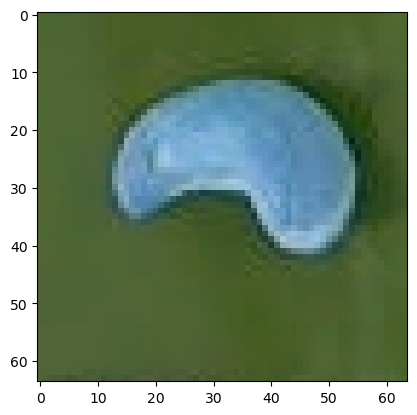

In [82]:
image_color = cv2.imread(cashew[100])
plt.imshow(image_color)

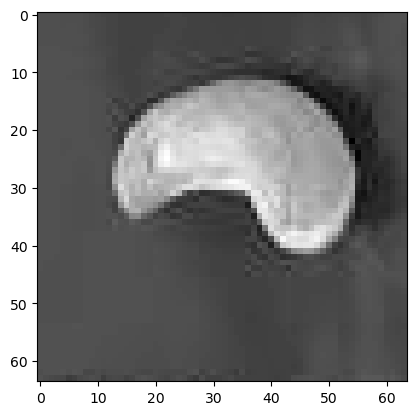

In [83]:
image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap = 'gray')

# GET HOG FEATURES

In [84]:
features, hog_image = hog(image_gray, 
                          orientations = 11, 
                          pixels_per_cell = (16, 16), 
                          cells_per_block = (2, 2), 
                          transform_sqrt = False, 
                          visualize = True, 
                          feature_vector = True)
features.shape 

(396,)

In [85]:
hog_image.shape

(64, 64)

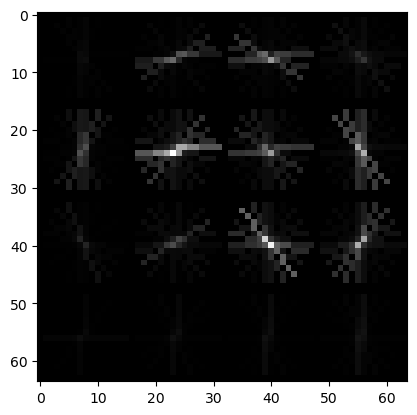

In [86]:
plt.imshow(hog_image, cmap = 'gray')

# HOG FEATURE EXTRACTION AND TRAINING DATASET CREATION

HOG with cashew

In [87]:
cashew_hog_accum = []
for i in cashew:
    image_color = mpimg.imread(i)
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
    cashew_hog_feature, car_hog_img = hog(image_color[:,:,0], 
                                    orientations = 11, 
                                    pixels_per_cell = (16, 16), 
                                    cells_per_block = (2, 2), 
                                    transform_sqrt = False, 
                                    visualize = True, 
                                    feature_vector = True)
    cashew_hog_accum.append(cashew_hog_feature)

In [88]:
X_cashew = np.vstack(cashew_hog_accum).astype(np.float64)  
y_cashew = np.ones(len(X_cashew))

In [89]:
X_cashew.shape

(207, 396)

In [90]:
y_cashew.shape

(207,)

HOG with no cashew

In [91]:
nocashew_hog_accum = []
for i in no_cashew:
    image_color = mpimg.imread(i)
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
    nocashew_hog_feature, car_hog_img = hog(image_color[:,:,0], 
                                    orientations = 11, 
                                    pixels_per_cell = (16, 16), 
                                    cells_per_block = (2, 2), 
                                    transform_sqrt = False, 
                                    visualize = True, 
                                    feature_vector = True)
    nocashew_hog_accum.append(nocashew_hog_feature)

In [92]:
X_nocashew = np.vstack(nocashew_hog_accum).astype(np.float64)  
y_nocashew = np.zeros(len(X_nocashew))

In [93]:
X_nocashew.shape

(306, 396)

In [94]:
y_nocashew.shape

(306,)

Ghép 2 cái lại

In [95]:
X = np.vstack((X_cashew, X_nocashew))
X.shape

(513, 396)

In [96]:
y = np.hstack((y_cashew, y_nocashew))
y.shape

(513,)

# SVM MODEL CLASSIFIER TRAINING 

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [98]:
cv2_svm = cv2.ml.SVM_create()
cv2_svm.setType(cv2.ml.SVM_C_SVC)
cv2_svm.setKernel(cv2.ml.SVM_LINEAR)
cv2_svm.train(np.float32(X_train), cv2.ml.ROW_SAMPLE, np.int32(y_train))

True

In [99]:
hog_cv2 = cv2.HOGDescriptor()

# TEST THE MODEL (FIND CARS)!

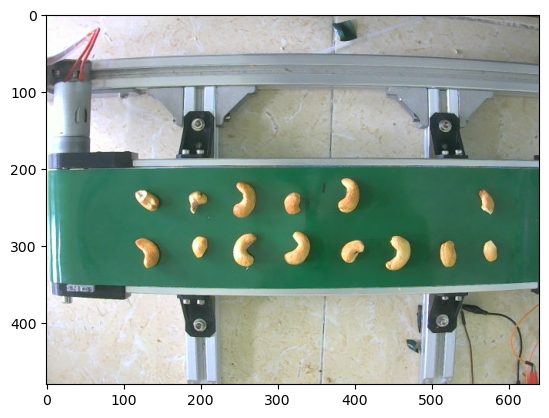

In [100]:
test_image = mpimg.imread('data/raw_data/frame_1324.png')
plt.imshow(test_image)
# test_image = test_image.astype(np.float32)/255

(128, 640, 3)

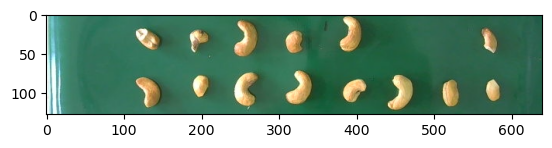

In [101]:
h_start = 210
h_stop = 338

pixels_in_cell = 16
HOG_orientations = 11
cells_in_block = 2
cells_in_step = 2

masked_region = test_image[h_start:h_stop,:,:]
plt.imshow(masked_region)
masked_region.shape

In [102]:
resizing_factor = 1
masked_region_shape = masked_region.shape
L = masked_region_shape[1]/resizing_factor
W = masked_region_shape[0]/resizing_factor

(128, 640, 3)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24788\810096792.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masked_region_resized = cv2.resize(masked_region, (np.int(L), np.int(W)))


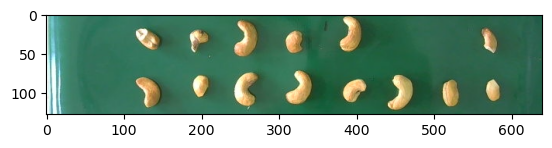

In [103]:
masked_region_resized = cv2.resize(masked_region, (np.int(L), np.int(W)))
masked_region_resized_R = masked_region_resized[:,:,0]

print(masked_region_resized.shape)
plt.imshow(masked_region_resized)

In [104]:
print(masked_region_resized_R.shape)    
masked_region_hog_feature_all, hog_img = hog(masked_region_resized_R, orientations = 11, pixels_per_cell = (16, 16), cells_per_block = (2, 2), transform_sqrt = False, visualize = True, feature_vector = False)

(128, 640)


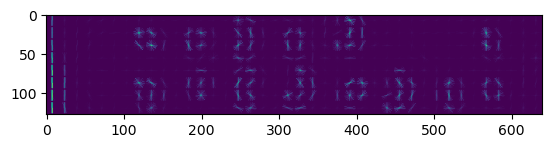

In [105]:
plt.imshow(hog_img)

In [106]:
masked_region_hog_feature_all.shape

(7, 39, 2, 2, 11)

In [112]:
n_blocks_x = (masked_region_resized_R.shape[1] // pixels_in_cell)+1  
n_blocks_y = (masked_region_resized_R.shape[0] // pixels_in_cell)+1

#nfeat_per_block = orientations * cells_in_block **2 
blocks_in_window = (64 // pixels_in_cell)-1 
    
steps_x = (n_blocks_x - blocks_in_window) // cells_in_step
steps_y = (n_blocks_y - blocks_in_window) // cells_in_step

rectangles_found = []
my_bool = 0

for xb in range(steps_x):
    for yb in range(steps_y):
        y_position = yb*cells_in_step
        x_position = xb*cells_in_step
            
        hog_feat_sample = masked_region_hog_feature_all[y_position : y_position + blocks_in_window, x_position : x_position + blocks_in_window].ravel()
        x_left = x_position * pixels_in_cell
        y_top = y_position * pixels_in_cell
        print(hog_feat_sample.shape)  
        
        # predict using trained SVM
        #test_prediction = svc_model.predict(hog_feat_sample.reshape(1,-1))
        test_prediction = cv2_svm.predict(hog_feat_sample.reshape(1,-1))
        #test_prediction_proba = cv2_svm.predict_proba(hog_feat_sample.reshape(1,-1))
        
        if test_prediction == 1:
            #if test_prediction_proba[0][1] > 0.75:
            rectangle_x_left = np.int(x_left * resizing_factor)
            rectangle_y_top = np.int(y_top * resizing_factor)
            window_dim = np.int(64 * resizing_factor)
            rectangles_found.append(((rectangle_x_left, rectangle_y_top + h_start),(rectangle_x_left + window_dim, rectangle_y_top + window_dim + h_start)))
            print("Predict: "+str(test_prediction)+", predict_proba: ")
            my_bool = my_bool+1

(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)


In [113]:
rectangles_found

[]

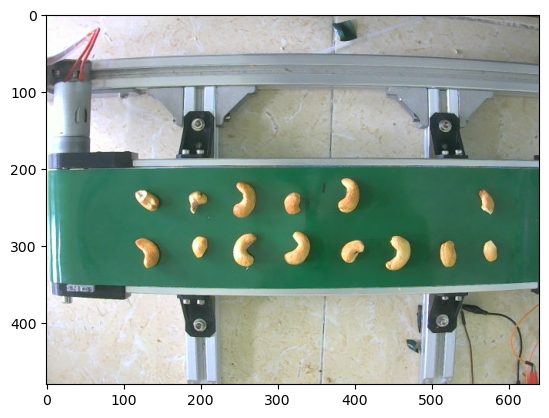

In [114]:
Image_with_Rectangles_Drawn = np.copy(test_image)
    
for rectangle in rectangles_found:
    cv2.rectangle(Image_with_Rectangles_Drawn, rectangle[0], rectangle[1], (0, 255, 0), 2)

plt.imshow(Image_with_Rectangles_Drawn)